In [1]:
import pyOSC3
import time
import random
import copy
from collections import namedtuple, defaultdict
from subprocess import Popen
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

from chord_utils import *
import elia_lrde_chords
import dale_kojas_chords
import kriste_aghsdga_chords

In [2]:
client = pyOSC3.OSCClient()
client.connect(('127.0.0.1', 57120))

In [18]:
DurableChord = namedtuple('DurableChord', ['chord', 'dur'])

def get_durable_chords(chords_source, chord_type):
    dur_chords = []
    chords = chords_source.get_chords()
    for i, chord in enumerate(chords):
        if chord_type == 'gvm':
            pitches = chord.gvm
        elif chord_type == 'tony':
            pitches = chord.tony
        else:
            assert(chord_type == 'redux')
            pitches = chord.redux
        
        if None in pitches:
            continue
        if max(pitches) - min(pitches) < 100:
            continue
        pitches.sort()
        if pitches[1] - pitches[0] < 15 or pitches[2] - pitches[1] < 15:
            continue

        assert(i < len(chords) - 1)
        dur = chords[i + 1].timestamp - chords[i].timestamp
        dur = np.clip(dur, 0.5, 1.5) * 2
        dur_chords.append(DurableChord([pitches[0] - pitches[1], 0, pitches[2] - pitches[1]], dur))
    return dur_chords

known_chords_list = []
known_chords_list += get_durable_chords(elia_lrde_chords, 'tony')
known_chords_list += get_durable_chords(dale_kojas_chords, 'gvm')
known_chords_list += get_durable_chords(kriste_aghsdga_chords, 'gvm')
print(len(known_chords_list))


219


In [19]:
mid_bees_hz = [255.86, 241.23, 248.75, 236.97, 241.47, 260.69, 246.21, 243.50, 241.39, 244.31, 242.95]
bot_bees_hz = [247.55, 258.51, 242.37, 252.82, 254.98, 246.06, 254.54, 251.91, 251.19]
top_bees_hz = [246.16, 247.13, 248.83, 248.53, 245.12, 251.28]
all_bees_hz = mid_bees_hz + bot_bees_hz + top_bees_hz

In [91]:
def send_msgs(hzs, sleep_time, voices=[0, 1, 2], do_send=True):
    def calc_rate(hz, bee_hz):
        if hz is None:
            return None
        return hz / bee_hz

    all_shifts = [len(mid_bees_hz), 0, len(mid_bees_hz) + len(bot_bees_hz)]
    all_timbre_counts = [len(bot_bees_hz), len(mid_bees_hz), len(top_bees_hz)]
    shifts = []
    timbre_counts = []
    for v in range(3):
        shifts.append(all_shifts[voices[v]])
        timbre_counts.append(all_timbre_counts[voices[v]])
    for i, hz in enumerate(hzs):
        cur_timbre = random.randint(0, timbre_counts[i] - 1) + shifts[i]
        rate = calc_rate(hz, all_bees_hz[cur_timbre])
        if do_send:
            try:
                msg = pyOSC3.OSCMessage()
                msg.setAddress("/bees")
                msg.append([rate, cur_timbre, sleep_time + 0.5])
                client.send(msg)
            except Exception as e:
                pass

def send_synth_msg(note, cur_timbre, out_bus_idx):
    try:
        msg = pyOSC3.OSCMessage()
        msg.setAddress("/synths")

        msg.append([note, cur_timbre, out_bus_idx])
        client.send(msg)
    except Exception as e:
        pass


In [21]:
min_hz = 200
ref_hz = 325
max_hz = 500

# print(calc_hz(-840, ref_hz), calc_hz(745, ref_hz))
# 200.0609671685489 499.7730307832097

200.0609671685489 499.7730307832097


In [22]:
def calc_two_steps(steps, cents_tolerance):
    two_steps = []
    for s1 in steps:
        if s1 < 50:
            continue
        for s2 in steps:
            if s2 < s1:
                continue
            two_steps.append(s1 + s2)
    return two_steps

cents_tolerance = 7
two_cents_tolerance = int(cents_tolerance * 1.5)
steps = [cents_tolerance, 100, 140, 165, 190]
two_steps = calc_two_steps(steps, cents_tolerance)
two_steps = sorted(set(two_steps))
print(two_steps)
all_steps = steps + two_steps
print(all_steps)

[200, 240, 265, 280, 290, 305, 330, 355, 380]
[7, 100, 140, 165, 190, 200, 240, 265, 280, 290, 305, 330, 355, 380]


In [23]:
seed = 8

In [38]:
def check_shift(voices, new_voices, steps, two_steps, cents_tolerance, two_cents_tolerance):
    for p in new_voices.chord:
        if not (min_hz < calc_hz(p, ref_hz) < max_hz):
            return False, None
    sum_steps = 0
    cur_steps = []
    for i in range(3):
        found = False
        p_diff = abs(voices.chord[i] - new_voices.chord[i])
        for s in steps:
            if abs(p_diff - s) < cents_tolerance:
                if s > 50:
                    sum_steps += 1
                    cur_steps.append(1)
                else:
                    cur_steps.append(0)
                found = True
                break
        if not found:
            for s in two_steps:
                if abs(p_diff - s) < two_cents_tolerance:
                    sum_steps += 2
                    cur_steps.append(2)
                    found = True
                    break
        if not found:
            return False, None
    if sum_steps > 4 or sum_steps < 2:
        return False, None
    return True, cur_steps

# seed += 1
print('seed', seed)
random.seed(seed)
chords = copy.deepcopy(known_chords_list)
random.shuffle(chords)
orig_chords = copy.deepcopy(known_chords_list)

song = []
voices = chords[0]
song.append(voices)
song_steps = []
stats = defaultdict(int)
song_dur = song[0].dur

while True:
    found = False
    random.shuffle(chords)
    for i, c in enumerate(chords):
        # compare voices and c
        for step in all_steps:
            for diff in [-1, 1]:
                for add in range(two_cents_tolerance):
                    for diff2 in [-1, 1]:
                        shift = step * diff + add * diff2
                        new_voices = DurableChord(list(np.array(c.chord) + shift), c.dur)
                        check_results, cur_steps = check_shift(voices, new_voices, steps, two_steps, cents_tolerance, two_cents_tolerance)
                        if check_results:
                            found = True
                            stats[orig_chords.index(chords[i])] += 1
                            song_steps.append(cur_steps)
                            break
                    if found:
                        break
                if found:
                    break
            if found:
                break
        if found:
            break

    if found:
        voices = new_voices
        song.append(voices)
        song_dur += voices.dur
    else:
        break

    if len(song) % 50 == 0:
        print(len(song), song_dur)

    if song_dur > 240:
        tonic = int((voices.chord[0] + voices.chord[1]) / 2)
        unison = DurableChord([tonic, tonic, tonic], 4)
        check_results, cur_steps = check_shift(voices, unison, steps, two_steps, cents_tolerance, two_cents_tolerance)
        if check_results:
            song.append(unison)
            song_steps.append(cur_steps)
            song_dur += unison.dur
            break
    if song_dur > 290:
        assert(False)
if song_dur < 270:
    assert(False)

print('final', seed, len(song), song_dur, 'vs', 270)

seed 8
50 76.37999999999997
100 158.12000000000012
150 227.66000000000008
final 8 175 271.28000000000003 vs 270


In [39]:
print(len(stats), stats)
for i, c in enumerate(song):
    print(c)

120 defaultdict(<class 'int'>, {109: 2, 90: 1, 49: 3, 27: 1, 165: 1, 91: 2, 71: 1, 145: 1, 12: 3, 209: 2, 123: 3, 72: 1, 179: 1, 66: 2, 58: 2, 95: 1, 129: 2, 135: 3, 13: 2, 84: 3, 174: 1, 26: 4, 157: 1, 89: 2, 134: 1, 106: 1, 102: 3, 142: 1, 35: 1, 62: 2, 211: 1, 92: 2, 152: 2, 120: 3, 48: 1, 156: 2, 11: 1, 169: 1, 2: 1, 63: 2, 3: 2, 78: 2, 183: 4, 42: 1, 151: 2, 216: 1, 197: 1, 178: 2, 101: 3, 51: 1, 28: 2, 1: 2, 199: 2, 47: 1, 147: 1, 137: 1, 94: 1, 202: 1, 54: 2, 22: 1, 217: 1, 110: 1, 85: 1, 60: 1, 161: 1, 207: 2, 81: 1, 29: 2, 0: 1, 100: 1, 16: 2, 39: 1, 198: 1, 6: 2, 189: 1, 118: 2, 160: 1, 36: 1, 25: 1, 177: 1, 148: 3, 9: 1, 215: 1, 10: 1, 119: 1, 153: 1, 86: 1, 128: 1, 80: 1, 74: 1, 139: 2, 195: 2, 23: 1, 144: 1, 130: 1, 107: 1, 146: 1, 196: 1, 187: 1, 154: 1, 77: 1, 55: 1, 149: 1, 45: 1, 210: 1, 99: 1, 41: 1, 172: 1, 30: 2, 18: 1, 121: 1, 21: 1, 214: 1, 204: 1, 87: 1, 191: 1, 38: 1, 171: 1, 14: 1, 52: 1})
DurableChord(chord=[-376, 0, 323], dur=1.0)
DurableChord(chord=[-574, 10

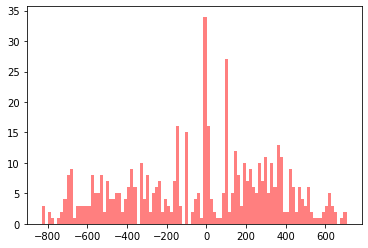

In [40]:
pitches = []
for c in song:
    for p in c.chord:
        pitches.append(p)

h = plt.hist(pitches, 100,
             density=False,
             histtype='bar',
             facecolor='r',
             alpha=0.5)

In [78]:
for i, c in enumerate(song):
    hzs = [calc_hz(p, ref_hz) for p in c.chord]
    for hz in hzs:
        send_synth_msg(hz, 0, 0)
    print(i, c)
    time.sleep(c.dur / 2)

0 DurableChord(chord=[-376, 0, 323], dur=1.0)
1 DurableChord(chord=[-574, 100, 460], dur=1.0)
2 DurableChord(chord=[-587, -99, 101], dur=2.219999999999999)
3 DurableChord(chord=[-441, 139, 260], dur=1.0)
4 DurableChord(chord=[-305, 140, 459], dur=1.9199999999999875)
5 DurableChord(chord=[-302, 274, 650], dur=1.0)
6 DurableChord(chord=[-205, 140, 444], dur=2.260000000000005)
7 DurableChord(chord=[-71, 281, 606], dur=2.6599999999999966)
8 DurableChord(chord=[-452, 268, 330], dur=1.0)
9 DurableChord(chord=[-248, 100, 493], dur=1.3200000000000003)
10 DurableChord(chord=[-443, 92, 262], dur=1.0)
11 DurableChord(chord=[-538, -14, 168], dur=2.420000000000016)
12 DurableChord(chord=[-813, -148, 5], dur=1.1200000000000045)
13 DurableChord(chord=[-671, -140, 368], dur=1.2399999999999949)
14 DurableChord(chord=[-300, -4, 360], dur=1.5)
15 DurableChord(chord=[-531, -147, 195], dur=2.780000000000001)
16 DurableChord(chord=[-677, -3, 357], dur=1.0)
17 DurableChord(chord=[-690, -6, 21], dur=1.1199999

KeyboardInterrupt: 

In [60]:
part_idx = 0
parts = []
parts_steps = []
for i, c in enumerate(song):
    if len(parts) <= part_idx:
        parts.append([])
        parts_steps.append([])
    parts[-1].append(c)
    if c.dur > 2.5 and len(parts[-1]) > 30:
        part_idx += 1
    else:
        parts_steps[-1].append(song_steps[i])
print([len(p) for p in parts])
assert(len(parts) == 4)    

swaps = []
for p_idx, song_part in enumerate(parts):
    for i, c in enumerate(song_part):
        if i > len(song_part) - 4:
            break
        if p_idx == 3 and i > len(song_part) - 7:
            break
        for v in range(3):
            ps = []
            ss = []
            for j in range(4):
                ps.append(song_part[i + j].chord[v])
                if j < 3:
                    ss.append(parts_steps[p_idx][i + j][v])
            if (ps[0] < ps[1] > ps[2] < ps[3]) or (ps[0] > ps[1] < ps[2] > ps[3]):
                continue
            swaps.append((p_idx, i, v))
#             print(i, v, ps, ss)
print(len(swaps))

[40, 46, 48, 41]
335


In [61]:
seed2 = seed
random.seed(seed2)

def remix(parts, parts_order, swaps, swaps_threshold):
    new_parts = copy.deepcopy(parts)
    for s in swaps:
        if random.random() < swaps_threshold:
            p_idx, n_idx, v = s
            phrase = []
            for k in [1, 2]:
                phrase.append(new_parts[p_idx][n_idx + k])
            n1, n2 = phrase[0].chord[v], phrase[1].chord[v]
            phrase[0].chord[v] = n2
            phrase[1].chord[v] = n1
            for k in [1, 2]:
                new_parts[p_idx][n_idx + k] = phrase[k - 1]
    new_song = []
    for p_idx in parts_order:
        for c in new_parts[p_idx]:
            new_c = DurableChord(c.chord, c.dur * random.uniform(0.8, 1.2))
            new_song.append(c)
    return new_song
    
song1 = remix(parts, [0, 1, 2, 3], swaps, 0)
song2 = remix(parts, [1, 0, 2, 3], swaps, 0.10)
song3 = remix(parts, [0, 1, 2, 3], swaps, 0.30)
song4 = remix(parts, [2, 1, 0, 3], swaps, 0.66)


In [62]:
# full_song = song1 + song2 + song3 + song4

In [63]:
for s in [song1, song2, song3, song4]:
    s_dur = 0
    for c in s:
        s_dur += c.dur
    print(len(s), s_dur)

# full_dur = 0
# for c in full_song:
#     full_dur += c.dur
# print(full_dur)

175 271.28000000000003
175 271.28000000000003
175 271.28000000000003
175 271.28000000000003


In [98]:
all_songs = [song1, song2, song3, song4]
cur_song = 3

cur_ts = 0
for s_idx in range(len(all_songs)):
    if s_idx == 0:
        seed3 = seed
        random.seed(seed3)
    for i, c in enumerate(all_songs[s_idx]):
        hzs = [calc_hz(p, ref_hz) for p in c.chord]
        if cur_ts < 10:
            hzs = [None, hzs[1], None]
        cur_ts += c.dur
        send_msgs(hzs, c.dur, voices=[1, 1, 1], do_send=(s_idx == cur_song))
        if s_idx == cur_song:
            print(i, c, cur_ts)
            time.sleep(c.dur)
print('done!')

0 DurableChord(chord=[-449, 99, 275], dur=1.0) 814.840000000001
1 DurableChord(chord=[-57, 303, 621], dur=3.0) 817.840000000001
2 DurableChord(chord=[-254, 205, 437], dur=2.260000000000005) 820.100000000001
3 DurableChord(chord=[-357, -4, 325], dur=3.0) 823.100000000001
4 DurableChord(chord=[-620, 107, 425], dur=1.8000000000000007) 824.900000000001
5 DurableChord(chord=[-265, -100, 357], dur=1.2199999999999989) 826.120000000001
6 DurableChord(chord=[-519, -234, 496], dur=1.6799999999999997) 827.800000000001
7 DurableChord(chord=[-625, 95, 52], dur=1.240000000000009) 829.040000000001
8 DurableChord(chord=[-527, 7, 193], dur=1.0) 830.040000000001
9 DurableChord(chord=[-688, -233, 22], dur=2.1200000000000045) 832.160000000001
10 DurableChord(chord=[-551, -140, 306], dur=2.960000000000001) 835.120000000001
11 DurableChord(chord=[-721, -380, 299], dur=1.3599999999999959) 836.480000000001
12 DurableChord(chord=[-398, -140, 206], dur=3.0) 839.480000000001
13 DurableChord(chord=[-494, -6, 200]

108 DurableChord(chord=[-531, -4, 360], dur=1.5) 983.7200000000015
109 DurableChord(chord=[-677, -147, 195], dur=2.780000000000001) 986.5000000000015
110 DurableChord(chord=[-690, -6, 357], dur=1.0) 987.5000000000015
111 DurableChord(chord=[-300, -308, 21], dur=1.1199999999999903) 988.6200000000015
112 DurableChord(chord=[-677, -3, 125], dur=1.0) 989.6200000000015
113 DurableChord(chord=[-776, -321, -66], dur=2.1200000000000045) 991.7400000000015
114 DurableChord(chord=[-581, -162, 295], dur=1.6799999999999997) 993.4200000000014
115 DurableChord(chord=[-601, -95, 108], dur=1.0) 994.4200000000014
116 DurableChord(chord=[-466, 104, -26], dur=1.8999999999999915) 996.3200000000014
117 DurableChord(chord=[-330, -265, 267], dur=1.0) 997.3200000000014
118 DurableChord(chord=[-745, 7, 369], dur=2.200000000000003) 999.5200000000015
119 DurableChord(chord=[-330, -139, 363], dur=2.239999999999995) 1001.7600000000015
120 DurableChord(chord=[-235, 242, 203], dur=1.1599999999999966) 1002.92000000000

In [87]:
# # test new samples

# for i, c in enumerate(full_song):
#     hzs = [calc_hz(p, ref_hz) for p in c.chord]
# #     hzs = [hzs[0], None, None]
# #     hzs = [None, hzs[1], None]
#     hzs = [None, None, hzs[2]]
#     send_msgs(hzs, 2)
#     print(i, c, cur_ts)
#     time.sleep(2)